In [1]:
# Kiểm tra cấu hình phần cứng GPU
!nvidia-smi

Mon Jun  2 09:06:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77.01              Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
|  0%   42C    P8             16W /  450W |    2177MiB /  24564MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Chuyển đường dẫn ra HOME
import os
HOME = os.getcwd()
print(HOME)

/home/chwenjun225/projects/Selarepa/src/models/yolov11


In [3]:
# Cài đặt yolo11 nếu chưa có 
# %pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Setup complete ✅ (32 CPUs, 31.2 GB RAM, 178.7/1006.9 GB disk)


In [4]:
# Test inference model pretrained với tập dữ liệu COCO
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100%|█████████████████████████████████████████| 104k/104k [00:00<00:00, 590kB/s]
image 1/1 /home/chwenjun225/projects/Selarepa/src/models/yolov11/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 29.2ms
Speed: 3.9ms preprocess, 29.2ms inference, 92.7ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


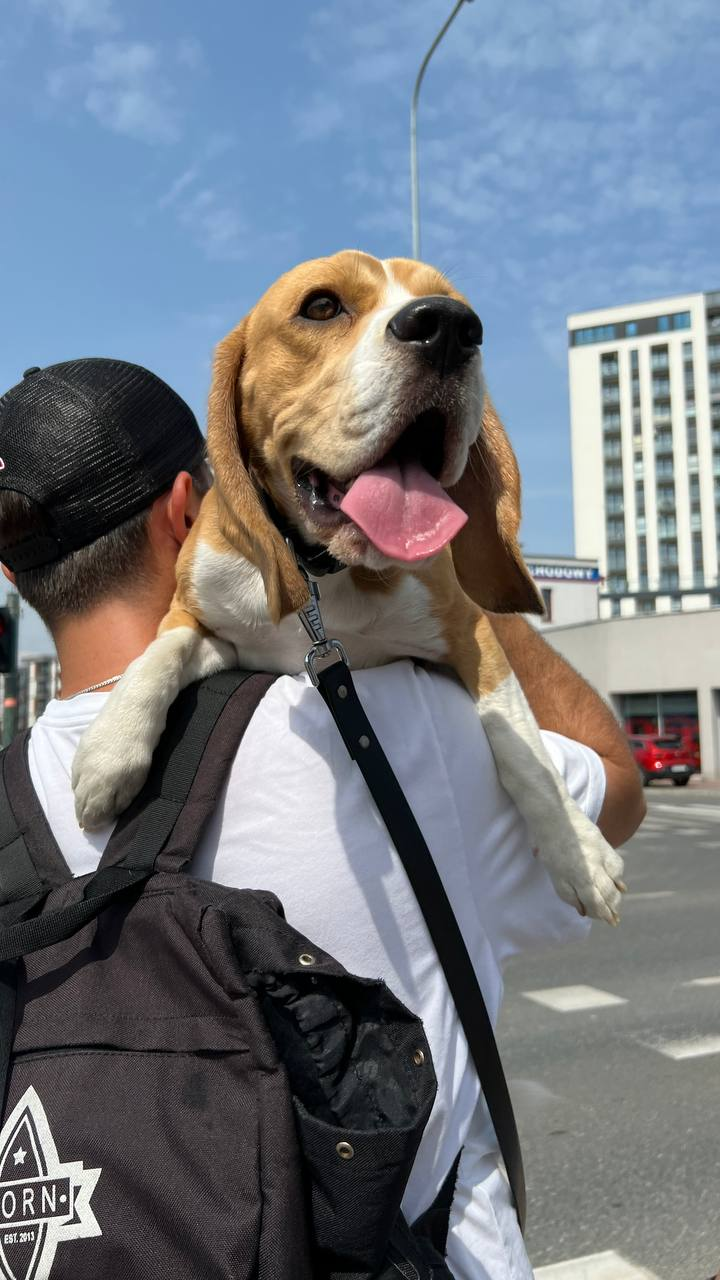

In [5]:
# Kết quả được lưu tại đường dẫn {HOME}/runs/detect/predict/
# Hiển thị nó bằng cách 
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/dog.jpeg', width=600)

In [ ]:
# YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]f


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 30.5ms
Speed: 5.0ms preprocess, 30.5ms inference, 82.7ms postprocess per image at shape (1, 3, 640, 384)


In [ ]:
# The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.
result.boxes.xyxy

tensor([[3.0705e+02, 6.4345e+02, 5.2920e+02, 1.2559e+03],
        [6.1285e+01, 2.4996e+02, 6.5168e+02, 9.7418e+02],
        [1.7423e+00, 3.5541e+02, 6.3416e+02, 1.2789e+03],
        [1.1875e+00, 3.5613e+02, 3.8473e+02, 1.2776e+03],
        [6.2615e+02, 7.1817e+02, 6.9974e+02, 7.8752e+02]], device='cuda:0')

In [10]:
# Confidence - phần trăm chính xác khi phát hiện một đối tượng
result.boxes.conf

tensor([0.6820, 0.6285, 0.5943, 0.3921, 0.3862], device='cuda:0')

In [11]:
# class - nhãn của đối tượng 
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

In [12]:
# YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

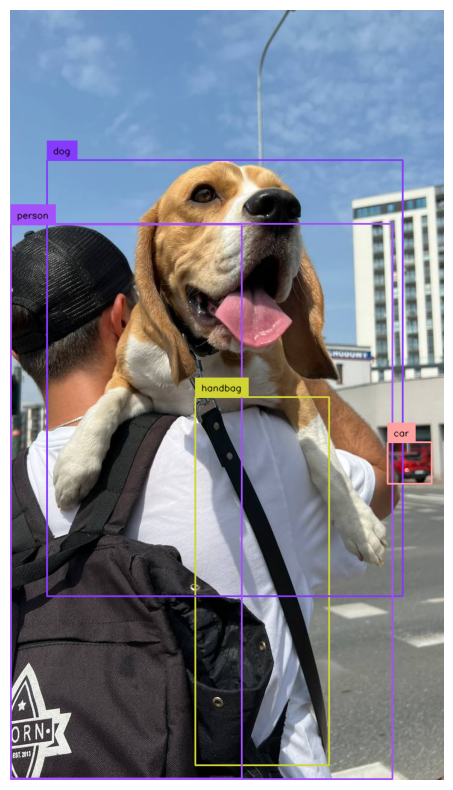

In [13]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

In [14]:
# Finetune YOLO11 với tập dữ liệu tùy chỉnh
# Khi training YOLOv11, dữ liệu huấn luyện của bạn cần phải nằm ở thư mục datasets. 
# Nếu muốn thay đổi bạn có thể thay đổi ở `settings.json`
# Ví dụ dưới đây, ta sử dụng một tập dữ liệu bất kỳ từ roboflow. Khi tải xuống hãy lựa chọn format dữ liệu cho YOLOv11

# !mkdir {HOME}/datasets
# %cd {HOME}/datasets

# from google.colab import userdata
# from roboflow import Roboflow

# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# workspace = rf.workspace("liangdianzhong")
# project = workspace.project("-qvdww")
# version = project.version(3)
# dataset = version.download("yolov11")

In [15]:
# Custom Training

# %cd {HOME}

# ! yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

In [ ]:
# chwenjun225 custom command training 
%cd {HOME}

! yolo \
	task=detect \
	mode=train \
	model=yolo11n.pt \
	data=/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/data.yaml \
	epochs=100 \
	imgsz=640 \
	plots=True

/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent
New https://pypi.org/project/ultralytics/8.3.93 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=

In [ ]:
# The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.
!ls {HOME}/runs/detect/train/

F1_curve.png					    train_batch1.jpg
PR_curve.png					    train_batch2.jpg
P_curve.png					    train_batch2790.jpg
R_curve.png					    train_batch2791.jpg
args.yaml					    train_batch2792.jpg
confusion_matrix.png				    val_batch0_labels.jpg
confusion_matrix_normalized.png			    val_batch0_pred.jpg
events.out.tfevents.1742436266.chwenjun225.62418.0  val_batch1_labels.jpg
labels.jpg					    val_batch1_pred.jpg
labels_correlogram.jpg				    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


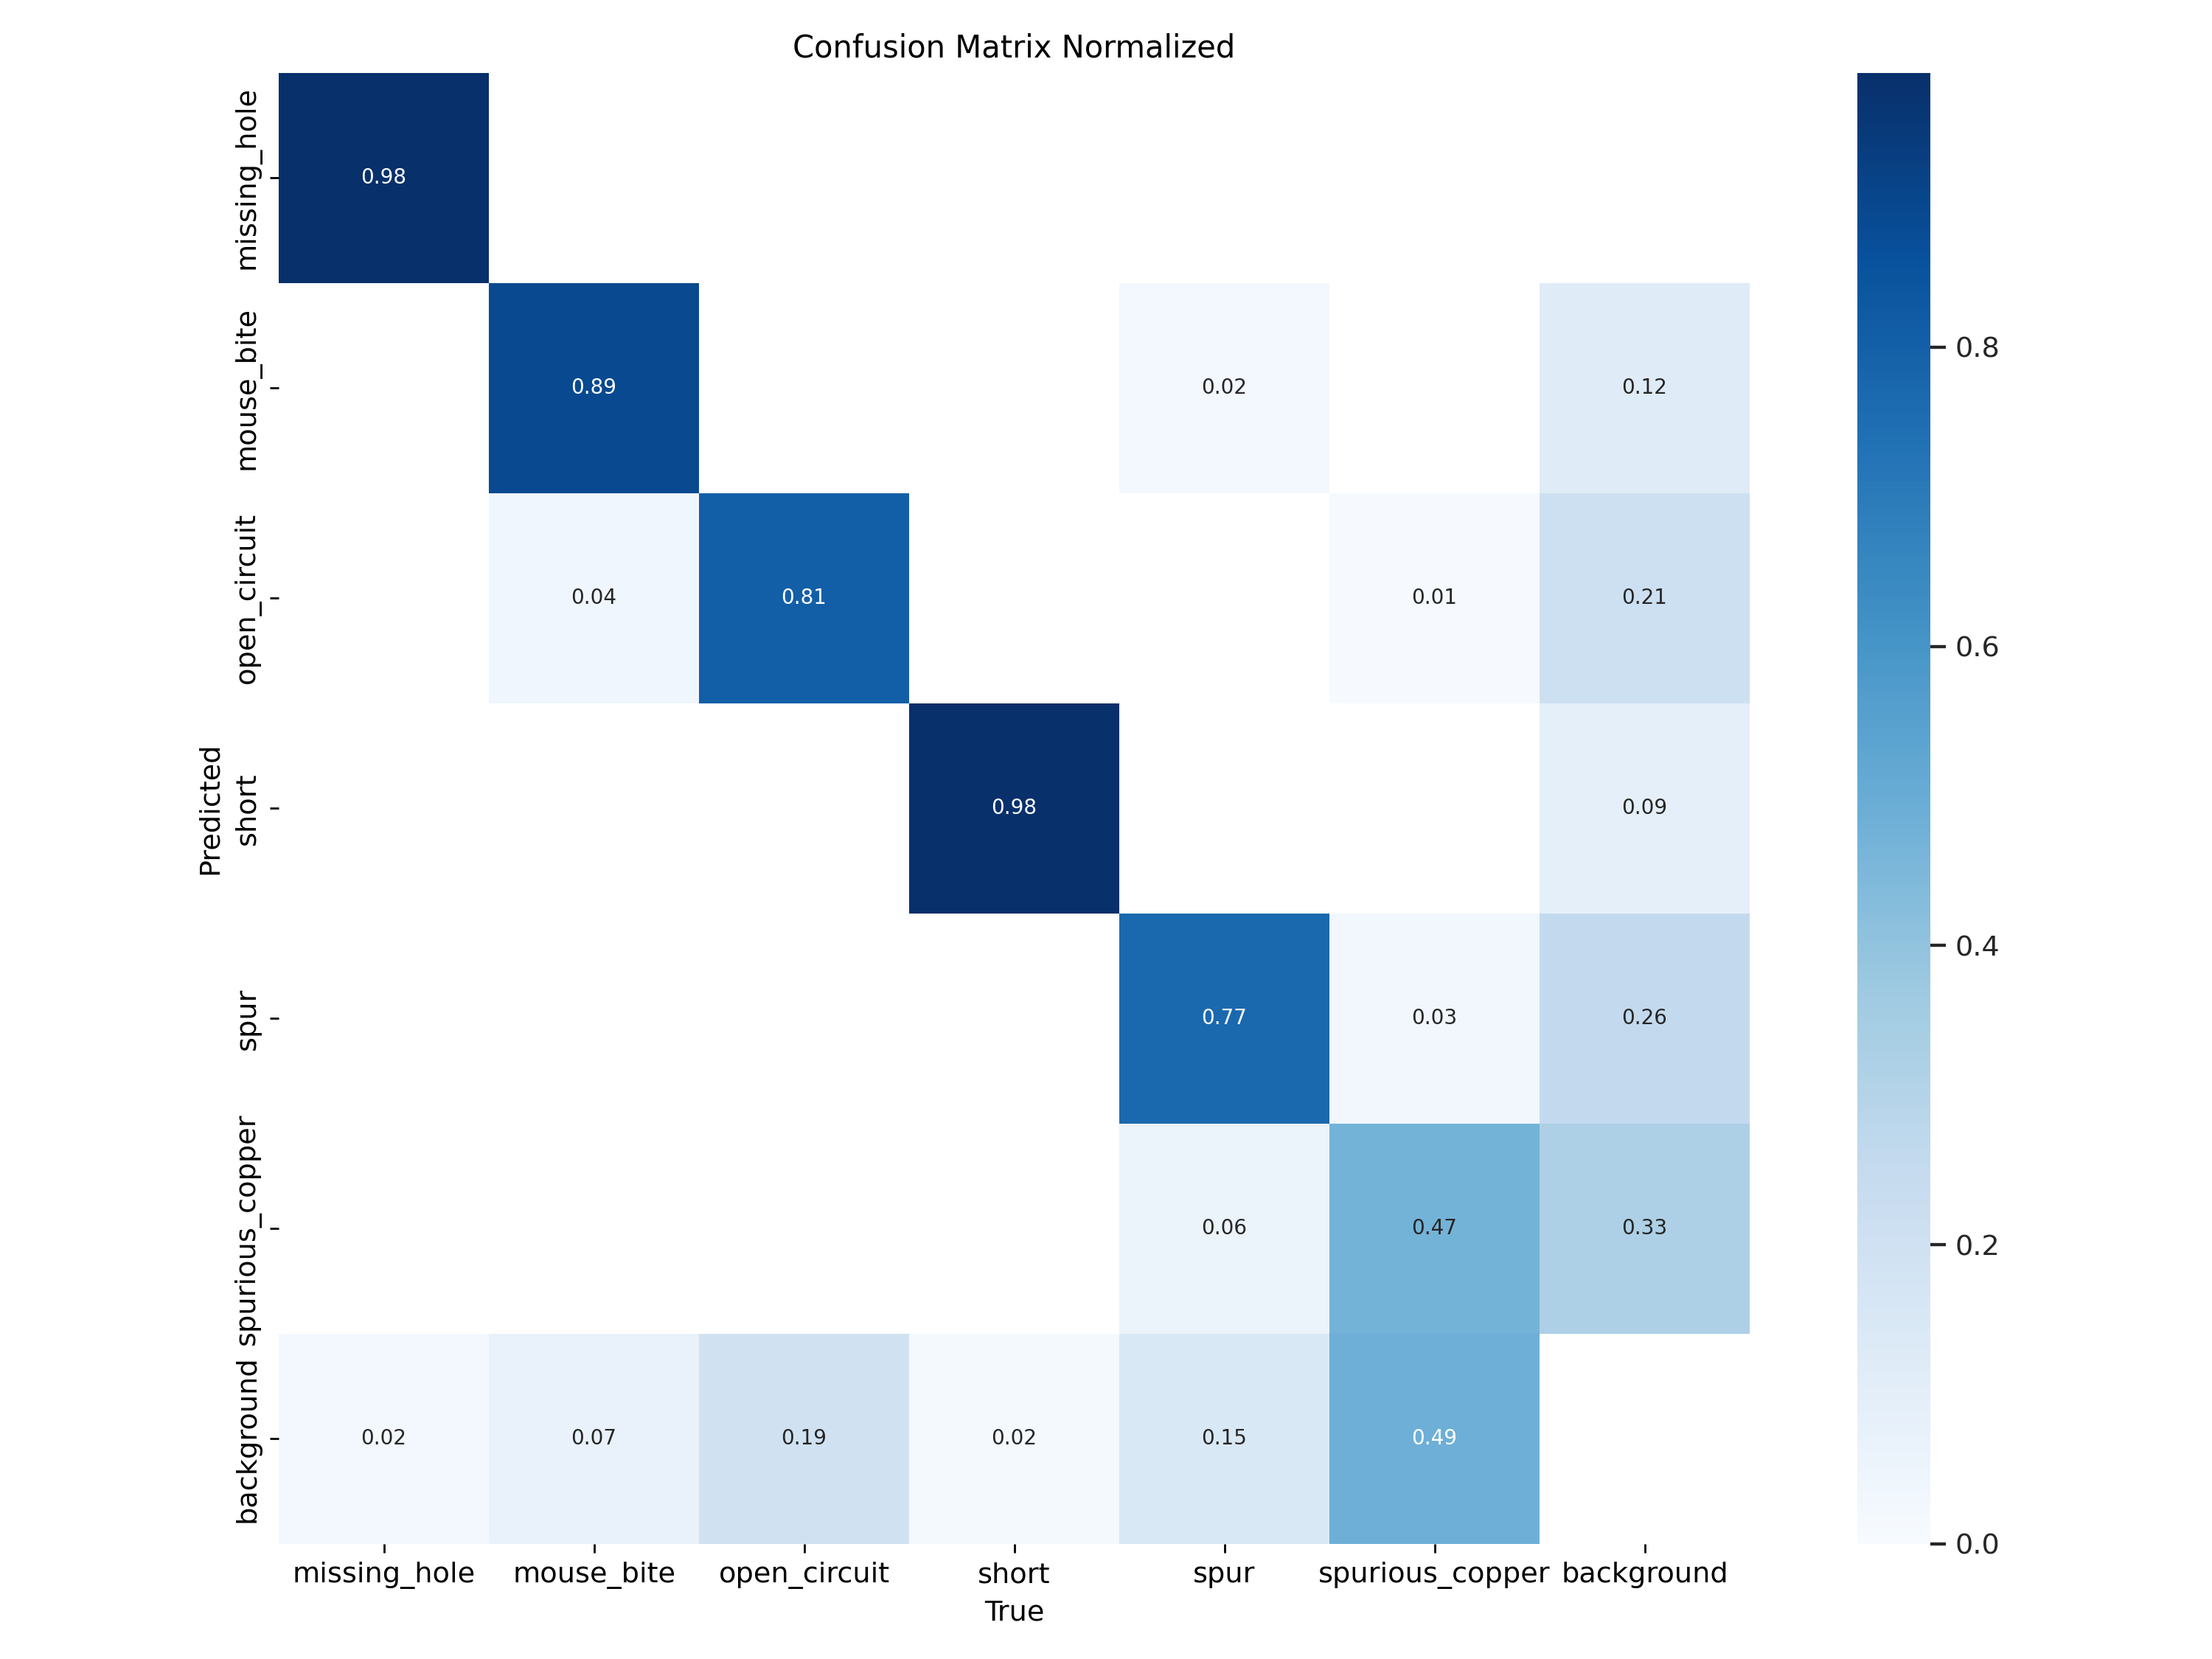

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=600)

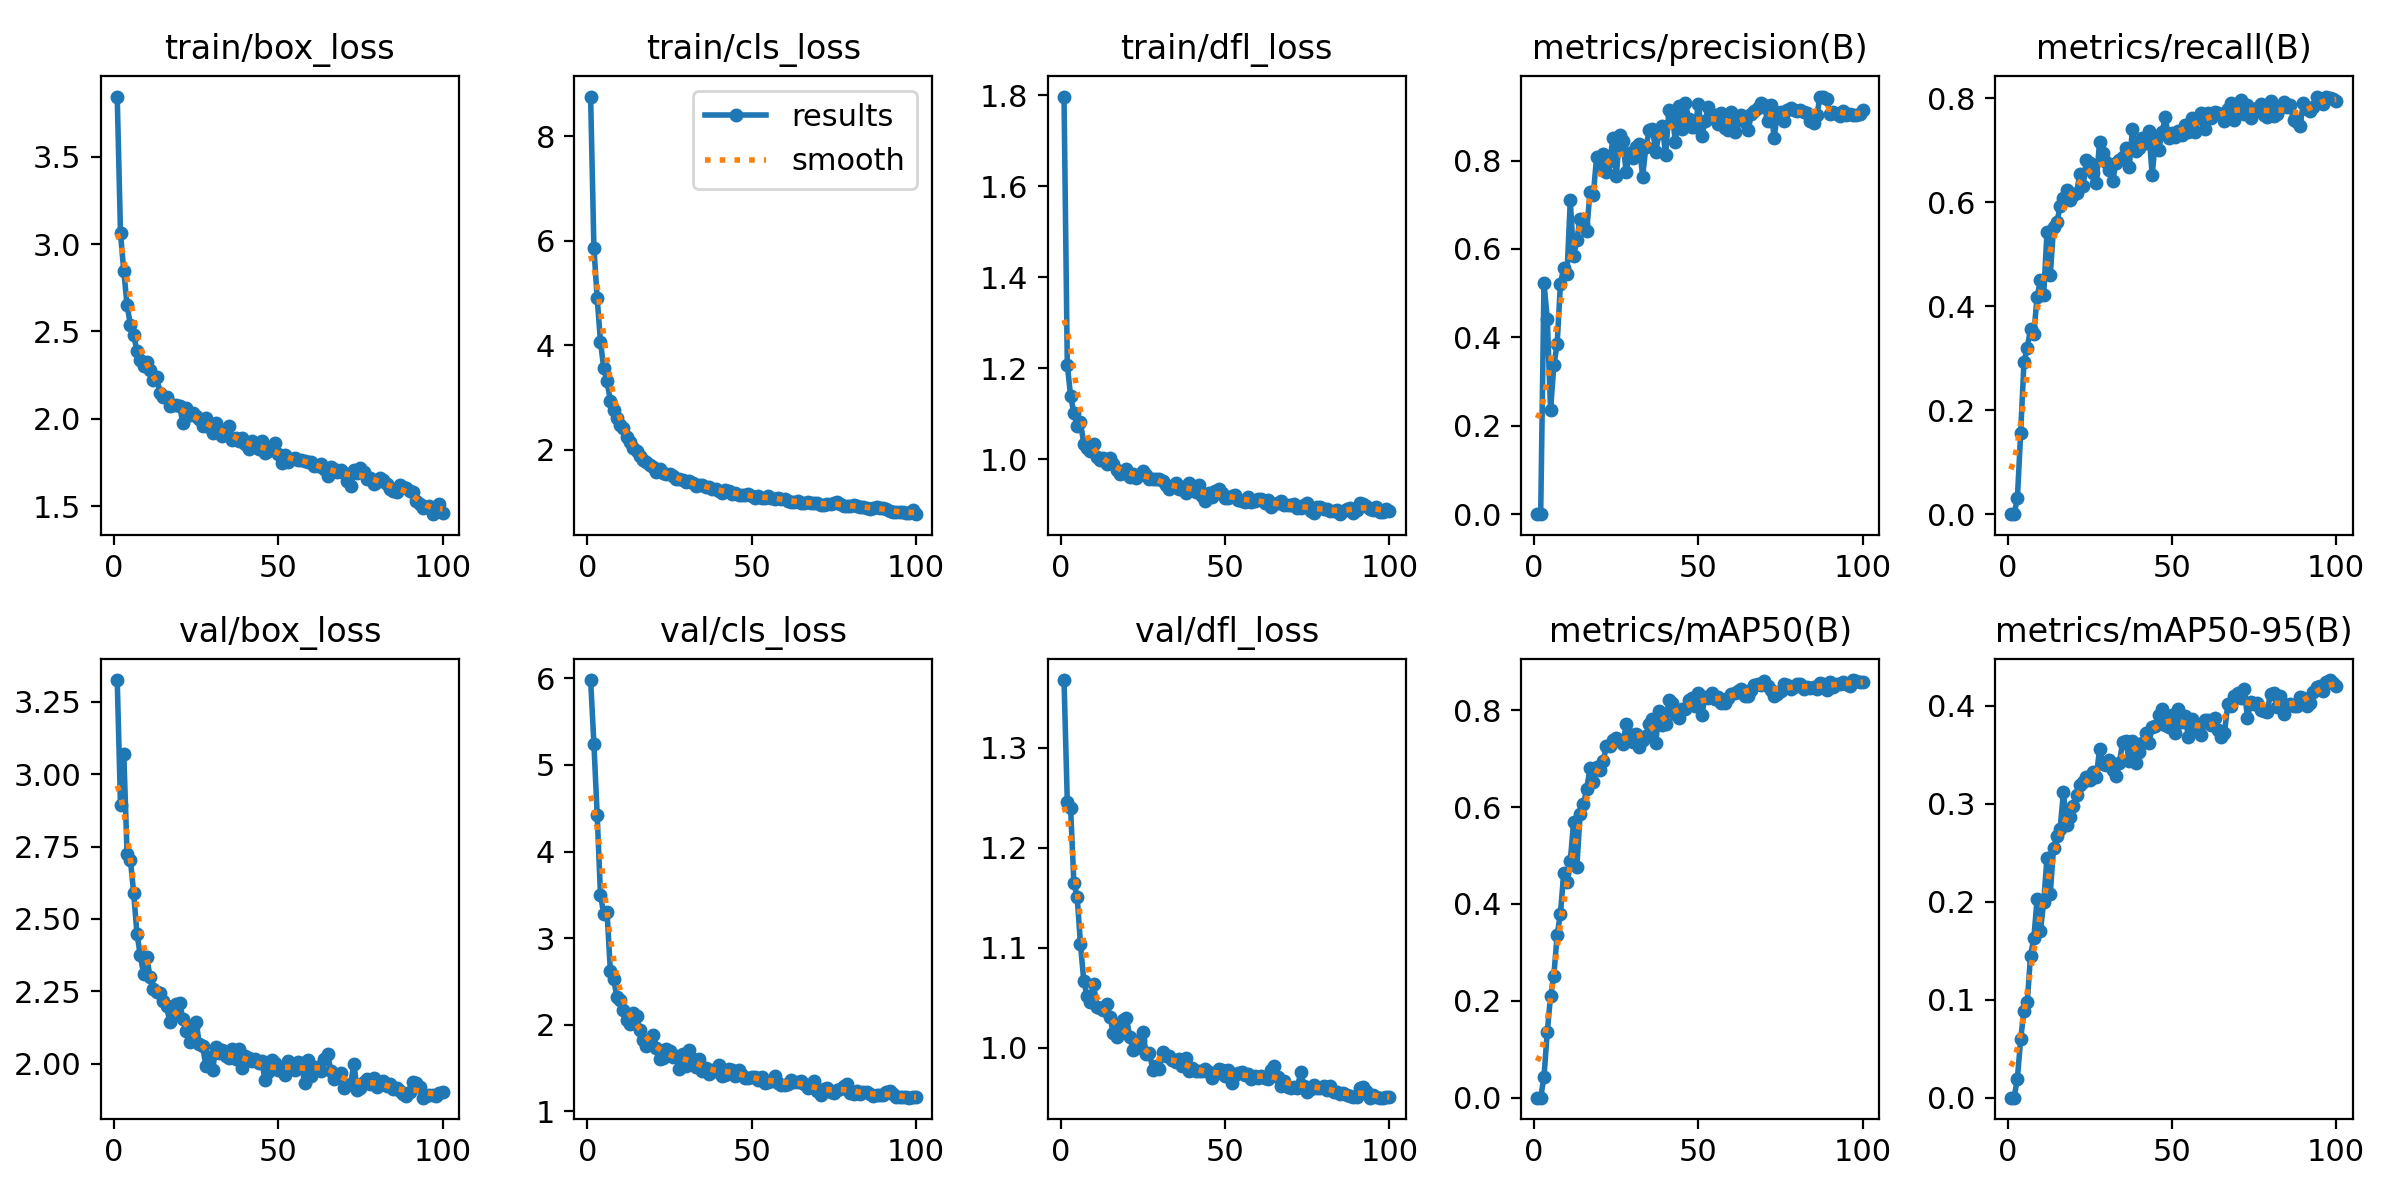

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

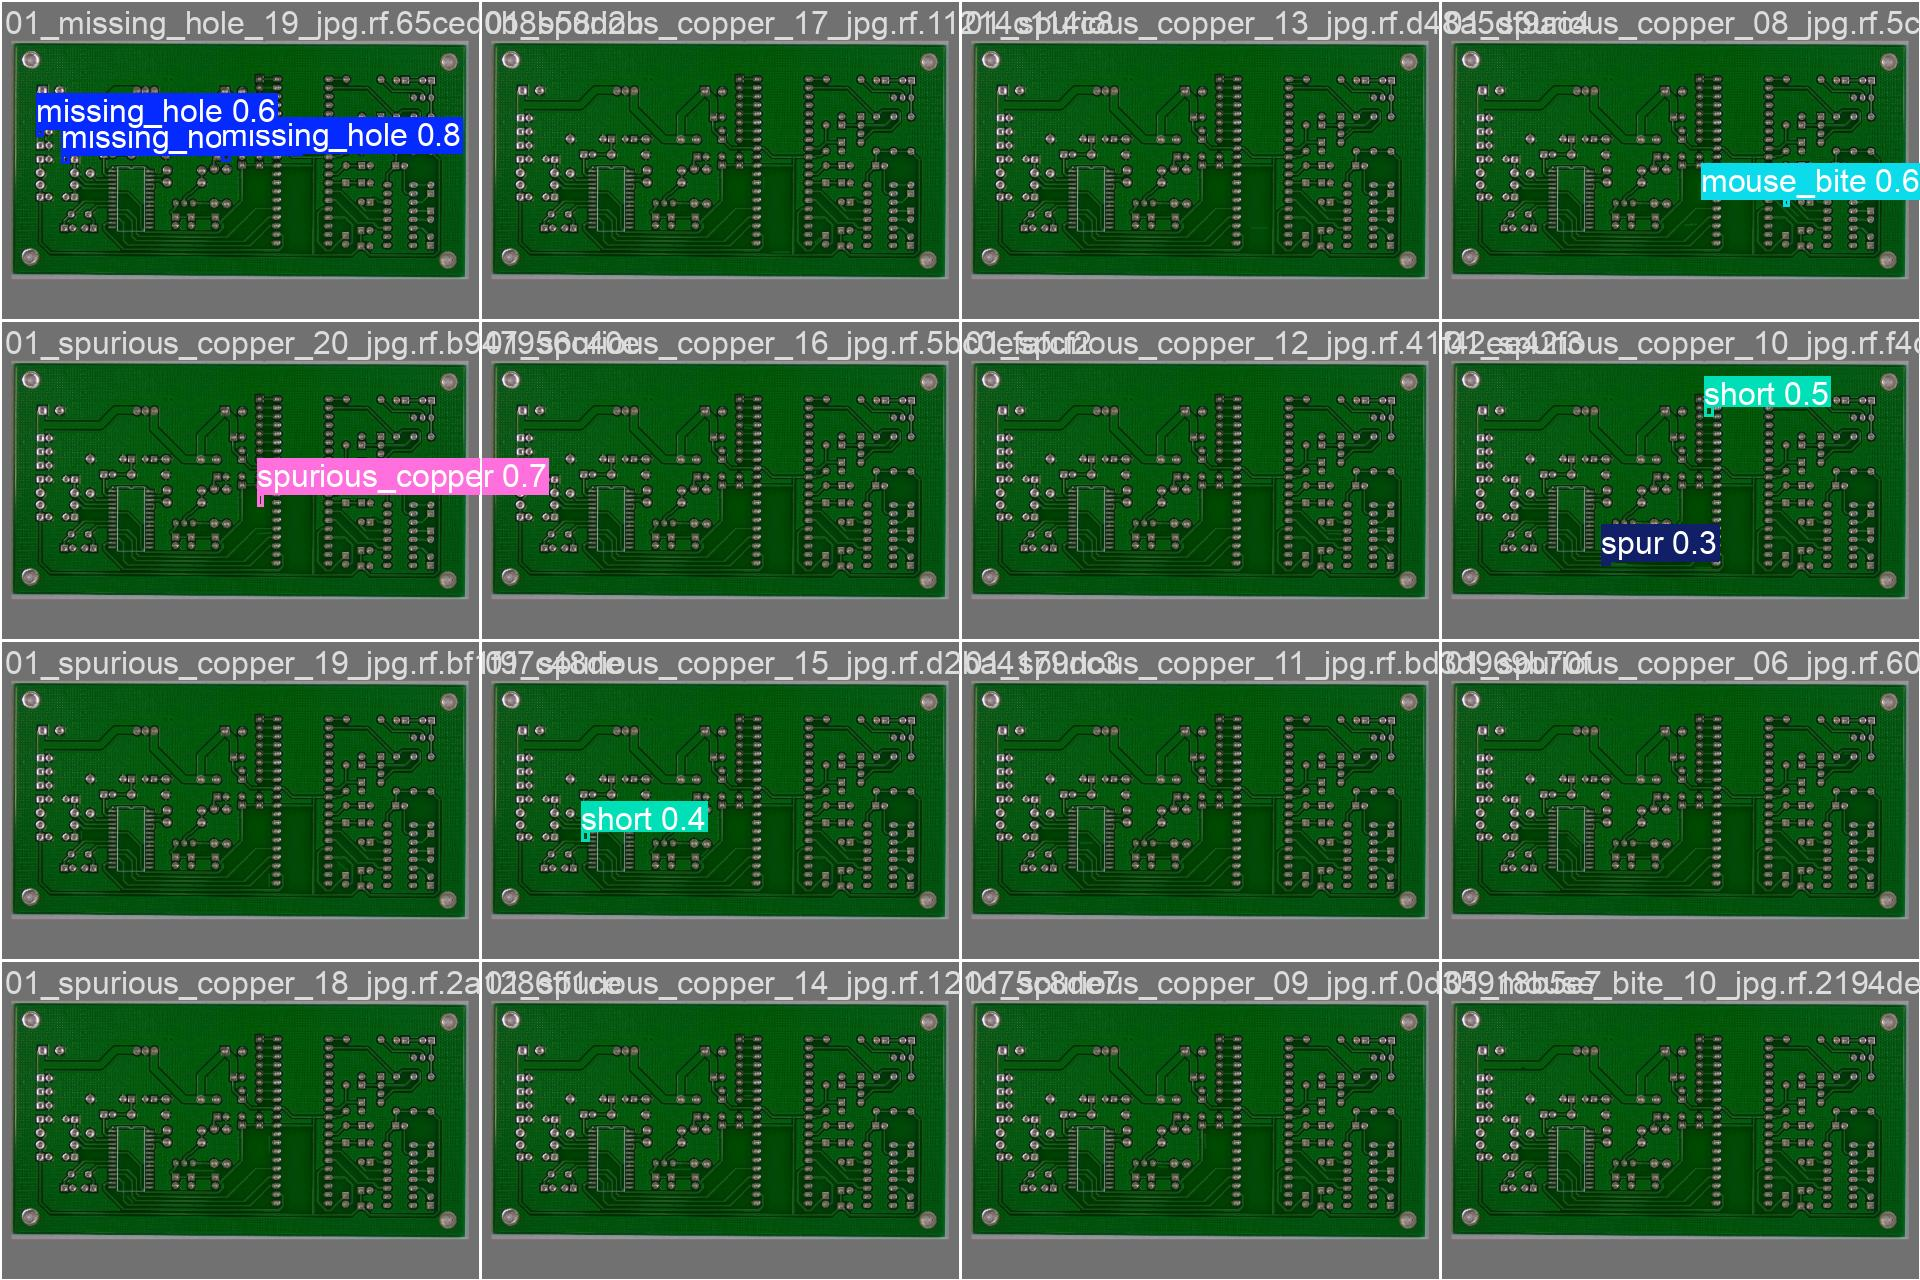

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
# Validate fine-tuned model
%cd {HOME}
! yolo task=detect mode=val \
	model=/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/runs/detect/train/weights/best.pt \
	data=/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/data.yaml

/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent
Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/d
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        139        583      0.909      0.802      0.862      0.423
          missing_hole         11         52      0.993      0.981      0.986      0.516
            mouse_bite         13         55      0.923      0.891      0.896      0.454
          open_circuit          8         31      0.829      0.806      0.876      0.383
                 short         15         60      0.907      0.971      0.979      0.516
                  spur         17         82      0.868      0.732      0.808      0.372
       spurious_copper         75        303      0.936    

In [ ]:
# Inference with custom model
!yolo task=detect mode=predict \
	model=/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/runs/detect/train/weights/best.pt \
	conf=0.25 \
	source=/home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/test/images \
	save=True

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11n summary (fused): 238 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs

image 1/69 /home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/test/images/01_missing_hole_14_jpg.rf.749415ea32feae07f84b650f781aecbc.jpg: 352x640 3 missing_holes, 28.5ms
image 2/69 /home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/test/images/01_open_circuit_01_jpg.rf.f6e1747ca6fcf14b9712db64c5085791.jpg: 352x640 2 open_circuits, 4.7ms
image 3/69 /home/chwenjun225/projects/DeepEngine/research/MAAOI/VisionAgent/datasets/vision_600x600_color_PCB_Defect_Detection_CV2_693.v2i.yolov11/test/images/01_open_circuit_20_jpg.rf.78cec1710a782dcc7d0b1b1f6a897009.jpg: 352x640 1 open_circuit, 8.3ms
image 4/69 /home/chwenjun225/projects/DeepEngine/research

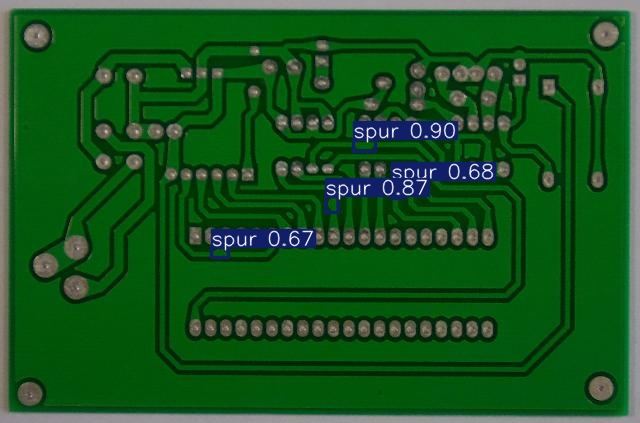

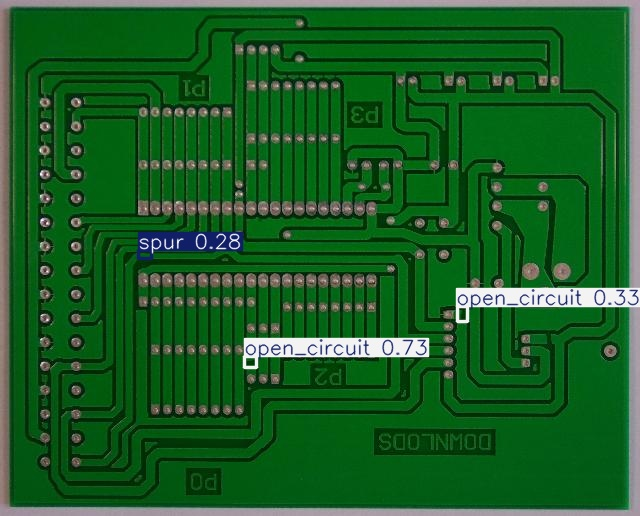

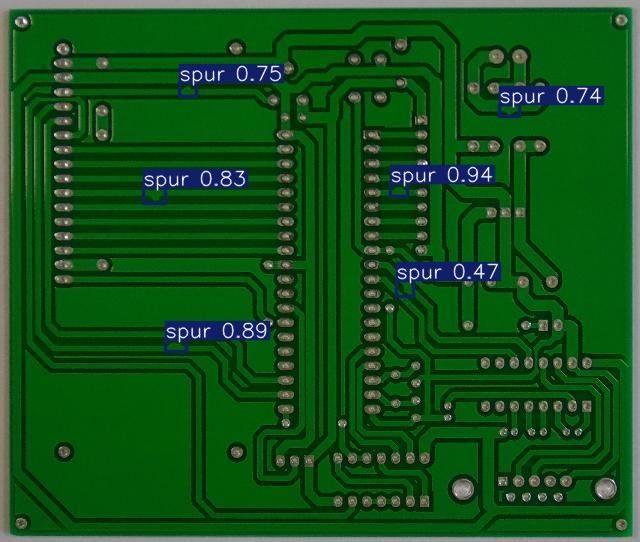

In [ ]:
# Let's take a look at few results.

import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
	display(IPyImage(filename=img, width=600))
	print("\n")

In [ ]:
# # Deploy model on Roboflow

# Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. 
# These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. 
# You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

# The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
# !pip install inference

In [ ]:
# import os, random, cv2
# import supervision as sv
# import IPython
# import inference

# model_id = project.id.split("/")[1] + "/" + dataset.version
# model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# # Location of test set images
# test_set_loc = dataset.location + "/test/images/"
# test_images = os.listdir(test_set_loc)

# # Run inference on 4 random test images, or fewer if fewer images are available
# for img_name in random.sample(test_images, min(4, len(test_images))):
# 	print("Running inference on " + img_name)

# 	# Load image
# 	image = cv2.imread(os.path.join(test_set_loc, img_name))

# 	# Perform inference
# 	results = model.infer(image, confidence=0.4, overlap=30)[0]
# 	detections = sv.Detections.from_inference(results)

# 	# Annotate boxes and labels
# 	box_annotator = sv.BoxAnnotator()
# 	label_annotator = sv.LabelAnnotator()
# 	annotated_image = box_annotator.annotate(scene=image, detections=detections)
# 	annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# 	# Display annotated image
# 	_, ret = cv2.imencode('.jpg', annotated_image)
# 	i = IPython.display.Image(data=ret)
# 	IPython.display.display(i)


In [ ]:
# ## 🏆 Congratulations

# ### Learning Resources

# Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

# - [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
# - [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
# - [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
# - [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

# ### Convert data formats

# Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

# ### Connect computer vision to your project logic

# [Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.